# Fast haze removal implementation

In this notebook, we will implement the method described in the article "Fast Haze Removal for a Single Remote Sensing Image Using Dark Channel Prior".

### Import of libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
# import holidays
from datetime import datetime, timedelta, date
import matplotlib.pyplot as plt
import rasterio
import os as os
from scipy.ndimage import gaussian_filter
import cv2

### Import of images

(10, 834, 834)
(834, 834, 10)


Text(0.5, 1.0, 'RGB bands of imported raster')

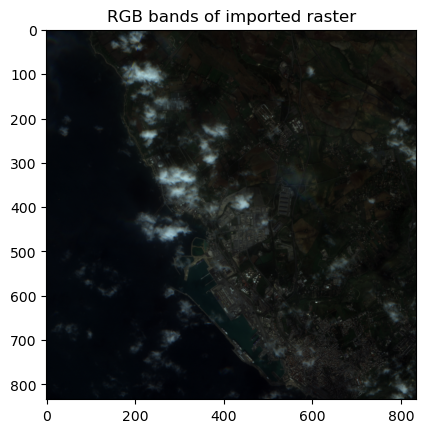

In [2]:
fp = "../raster/Italie_20221025T101111_20221025T101109_T33TTG__orbit_22_DESCENDING_timestamp_1666693150978_cloud_cov_50.401431.tif"

# Import array from raster (tif) file
with rasterio.open(fp) as src:
    img = src.read()
    print(img.shape)

# Set 0 values to nan to ignore them afterwards
img = np.where(img==0, np.nan, img)

# Transpose to get an (.,.,10) image with rgb bands
img = np.moveaxis(img, source=0, destination=-1)
print(img.shape)

# Extract rgb bands
rgb = img[:,:,[2,1,0]]

# Normalize bands
# img = (img-np.min(img, axis=(0,1)))/(np.max(img, axis=(0,1)))
rgb = (rgb-np.nanmin(rgb, axis=(0,1)))/(np.nanmax(rgb, axis=(0,1)))

# Plot the image
plt.imshow(rgb)
plt.title("RGB bands of imported raster")

### Algotihtm implementation

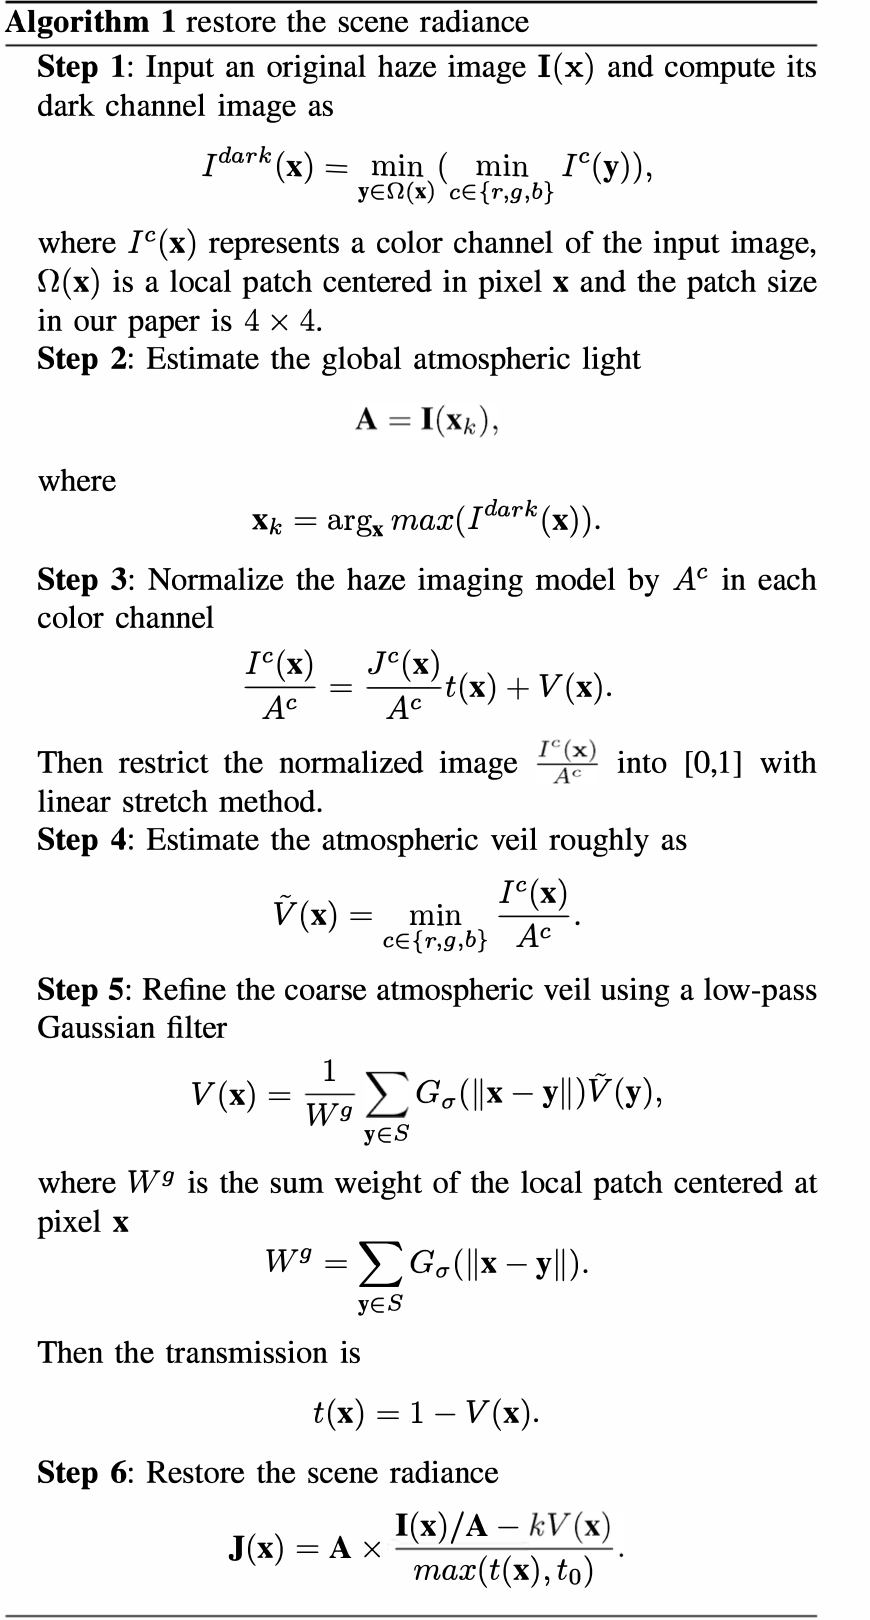

In [3]:
# Step 1
def dark_channel_prior(img, patch_size=4):
    """ Computes the dark channel of an image
    
    Inputs:
        img:           The input image
        patch_size:    The size of the neighborhood considered
                         
    Outputs: 
        img_dark       The dark image
    """

    h, w ,c = img.shape

    pad_img = np.array([np.pad(img[:,:,c], pad_width=patch_size) for c in range(img.shape[-1])])

    img_dark = np.zeros((h, w))
    
    for k in range(patch_size, h+patch_size):
        for j in range(patch_size, w+patch_size):
            
            img_dark[k-patch_size,j-patch_size] = np.nanmin(pad_img[: ,k-patch_size:k+patch_size+1, j-patch_size:j+patch_size+1])
    
    # Mask the dark channel so it has nans where original image has
    img_dark[np.isnan(img[:,:,0])] = np.nan

    return img_dark


# Step 2
def global_atmospheric_light(img, img_dark, patch_size=4):
    """ Computes the global atmospheric light of an image
        given its dark channel prior
    
    Inputs:
        img:           The input image
        img_dark:      The dark channel prior of the image
                         
    Outputs: 
        A              The global atmospheric light
    """

    xk = np.nanargmax(img_dark)
    xk = np.unravel_index(xk, img_dark.shape)

    # A = img[xk[1], xk[0]]
    A = img[xk]

    return A


# Step 3
def normalize(img, A):
    """ Normalizes the image by its global atmospheric light
        and stretches the values to [0,1]
    
    Inputs:
        img:           The input image
        A              The global atmospheric light
                         
    Outputs: 
        img_n          The image normalized by A and stretched to [0,1]
    """
    
    # Normalize by global atmospheric light
    img_n = img/A
    # Stretch to [0,1]
    img_n = (img_n - np.nanmin(img_n, axis=(0,1)))/np.nanmax(img_n, axis=(0,1))

    return img_n


# Steps 4 & 5
def atmospheric_veil(img_n, sigma=2):
    """ Estimates the atmospheric veil of the
        normalized image and smooths it

    Inputs:
        img_n:           The normalized image
                         
    Outputs: 
        V                The estimated atmospheric veil
    """ 
    
    V = np.nanmin(img_n, axis=2)
    V = gaussian_filter(V, sigma=sigma)
    V = np.expand_dims(V, axis=-1)

    return V

def transmission(V):
    t = 1 - V
    return t


# Step 6
def restore_radiance(img, A, V, t, t0=1, k=1):
    """ Restore scene radiance after haze removal

    Inputs:
        img:           The input image
        A:             The global atmospheric light
        V:             The estimated atmospheric veil
        t:             The estimated transmission
        t0:            Lower bound on transmission t
        k:             Parameter to keep a small amount of haze
                       from distant objects

    Outputs: 
        J              The restored scene radiance
    """ 
    
    J = A*((img/A) - k*V)/np.maximum(t, t0)

    return J


# Wrap up
def dehazing(img, patch_size=4, sigma=2, t0=0.4, k=0.7):
    
    # Dark channel prior
    img_dark = dark_channel_prior(img, patch_size)
    # Global atmospheric light
    A = global_atmospheric_light(img, img_dark)
    # Normalization
    img_n = normalize(img, A)
    # Atmospheric veil
    V = atmospheric_veil(img_n, sigma=sigma)
    # Transmission
    t = transmission(V)
    # Restored scene radiance
    J = restore_radiance(img, A, V, t, t0=t0, k=k)

    return J

# Helper functions to display the original and its computed restored radiance
def plot_steps(rgb, patch_size=4, sigma=2, t0=0.4, k=0.7):
    # Dark channel prior
    dark_channel_rgb = dark_channel_prior(rgb, patch_size)
    # Global atmospheric light
    A = global_atmospheric_light(rgb, dark_channel_rgb)
    print(A)
    # Normalization
    img_n = normalize(rgb, A)
    # Atmospheric veil
    V = atmospheric_veil(img_n, sigma=sigma)
    # Transmission
    t = transmission(V)
    # Restored scene radiance
    J = restore_radiance(rgb, A, V, t, t0, k)
    # Normalization
    J = (J-np.nanmin(J, axis=(0,1)))/(np.nanmax(J, axis=(0,1)))

    # Plot the different steps
    fig, axes = plt.subplots(1,6, figsize=(20,10))
    axes[0].imshow(rgb)
    axes[0].set_title("Original rgb image")
    axes[1].imshow(dark_channel_rgb, cmap='gray')
    axes[1].set_title("Darkchannel prior")
    axes[2].imshow(img_n)
    axes[2].set_title("Normalized image")
    axes[3].imshow(V, cmap='gray')
    axes[3].set_title("Atmospheric veil")
    axes[4].imshow(t, cmap='gray')
    axes[4].set_title("Transmission")
    axes[5].imshow(J)
    axes[5].set_title("Restored scene radiance")
    plt.suptitle("Different steps of the algorithm", y=0.7)


def plot_comparison(img, patch_size=4, sigma=2, t0=0.4, k=0.7):
    # Compute restored radiance
    J = dehazing(img, patch_size, sigma, t0, k)
    # Normalization
    J = (J-np.nanmin(J, axis=(0,1)))/(np.nanmax(J, axis=(0,1)))

    # Print original image vs result
    fig, axes = plt.subplots(2,2, figsize=(20,10))
    axes[0,0].imshow(img)
    axes[0,0].set_title("Original rgb image")
    axes[0,1].imshow(J)
    axes[0,1].set_title("Restored scene radiance")
    
    color = ('b','g','r')

    for i,col in enumerate(color):
        histr = cv2.calcHist([(img*255).astype(np.uint16)],[i],None,[256],[0,256])
        histJ = cv2.calcHist([(J*255).astype(np.uint16)],[i],None,[256],[0,256])
        axes[1,0].plot(histr,color = col)
        axes[1,1].plot(histJ,color = col)
        

### Tests

Global atmospheric light:  [0.65564854 0.80064071 0.81709381]


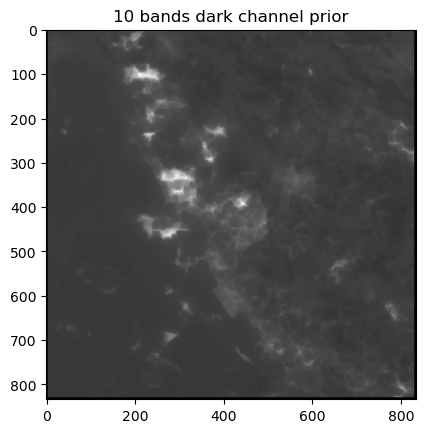

<Figure size 640x480 with 0 Axes>

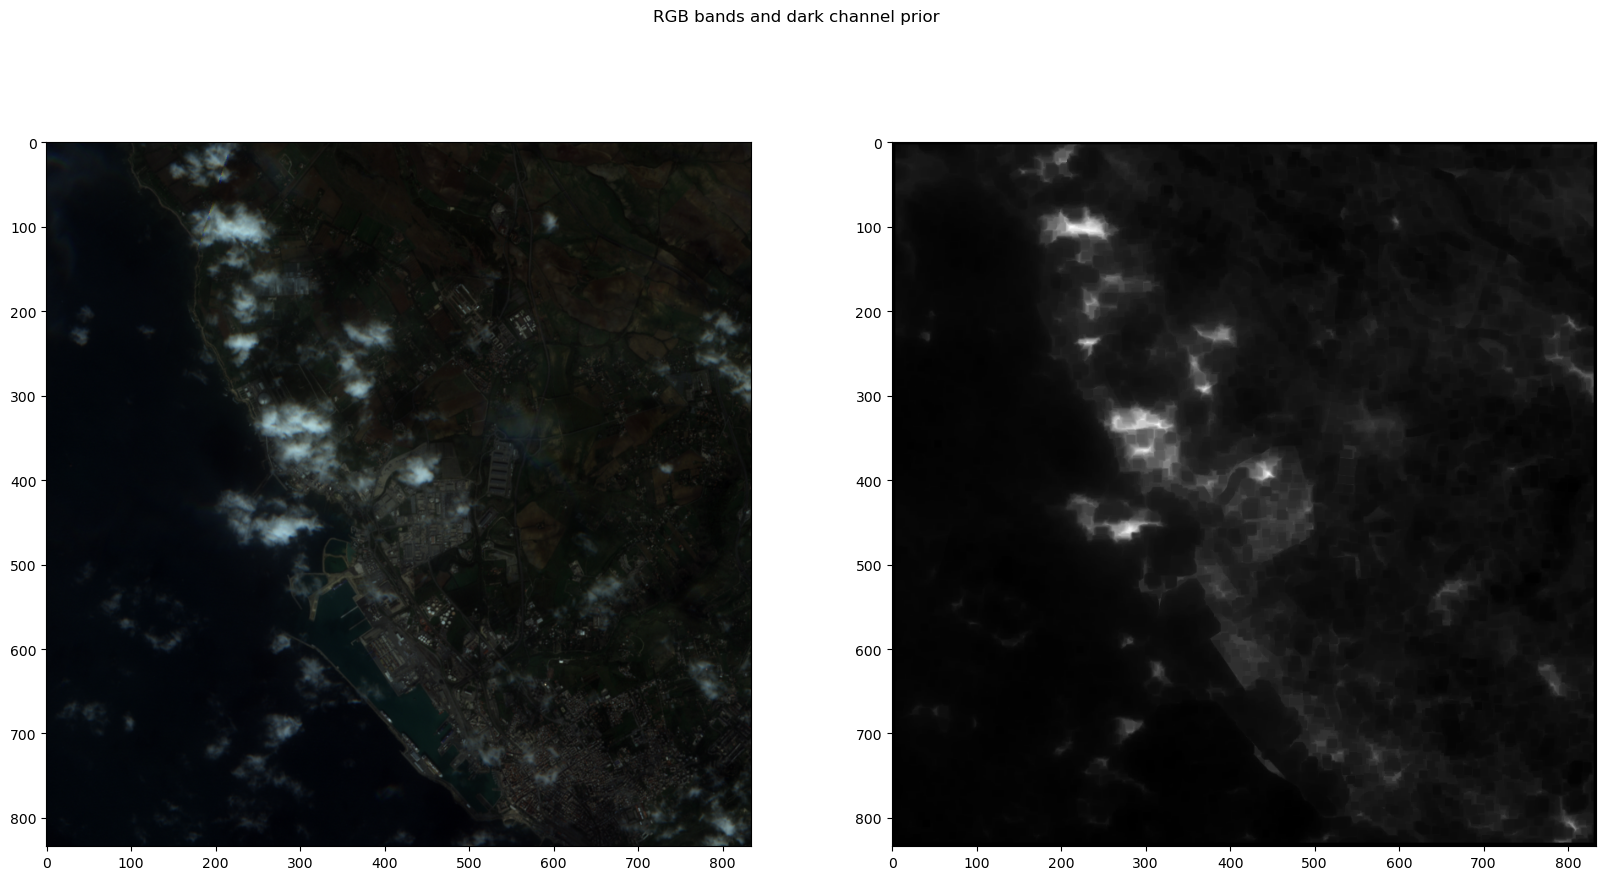

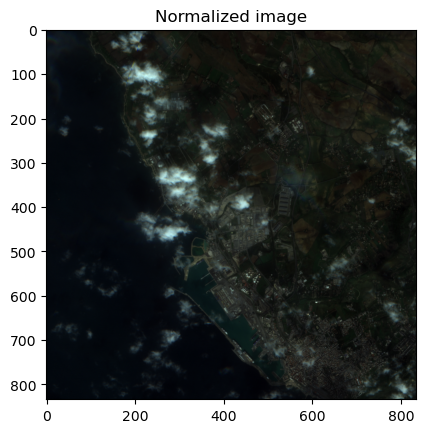

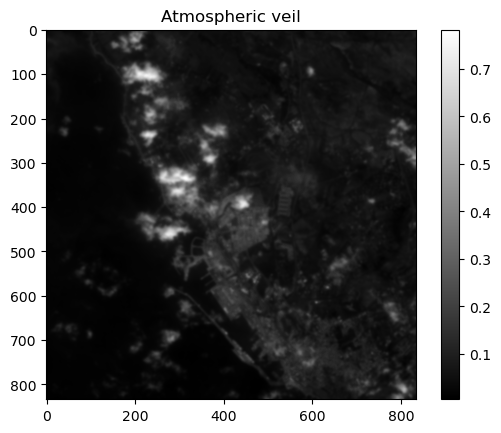

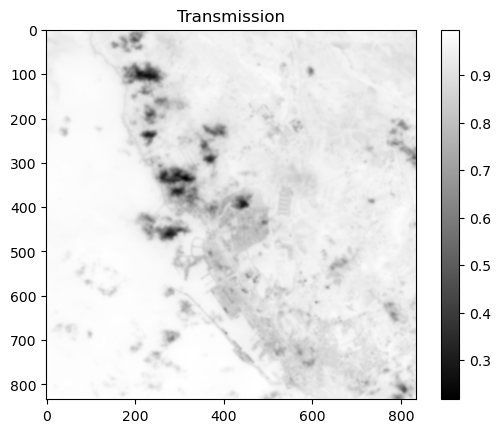

In [4]:
patch_size = 4

# On 10-bands image
dark_channel_img = dark_channel_prior(img, patch_size)
plt.figure()
plt.imshow(dark_channel_img, cmap='gray')
plt.title("10 bands dark channel prior")

# On RGB image
dark_channel_rgb = dark_channel_prior(rgb, patch_size)
plt.figure()
fig, axes = plt.subplots(1,2, figsize=(20,10))
axes[0].imshow(rgb)
axes[1].imshow(dark_channel_rgb, cmap='gray')
plt.suptitle("RGB bands and dark channel prior")

# Global atmospheric light
A = global_atmospheric_light(rgb, dark_channel_rgb)
print("Global atmospheric light: ", A)

# Normalization
img_n = normalize(rgb, A)
plt.figure()
plt.imshow(img_n)
plt.title("Normalized image")

# Atmospheric veil
V = atmospheric_veil(img_n)
plt.figure()
plt.imshow(V, cmap="gray")
plt.title("Atmospheric veil")
plt.colorbar()

# Transmission
t = transmission(V)
plt.figure()
plt.imshow(t, cmap="gray")
plt.title("Transmission")
plt.colorbar()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Restored scene radiance')

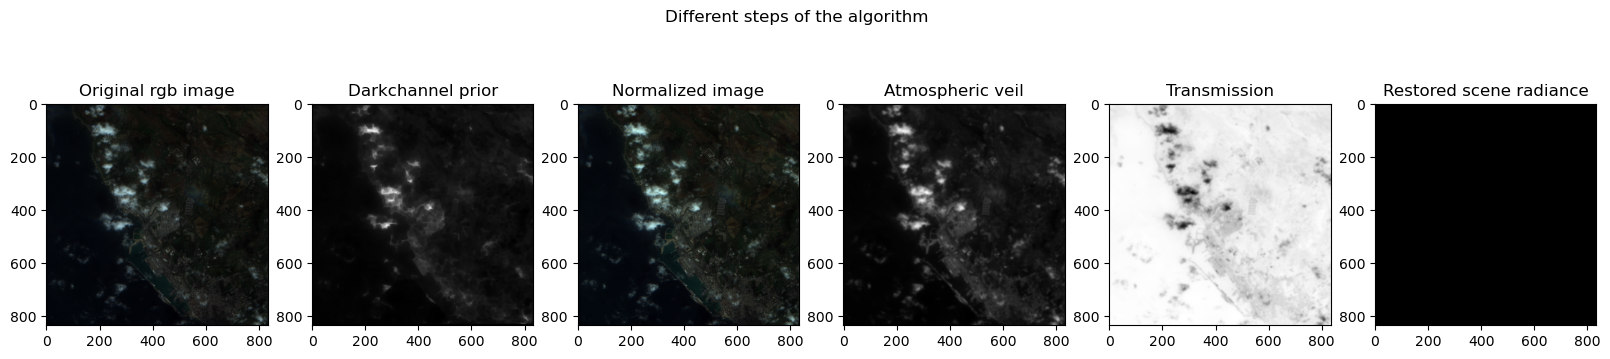

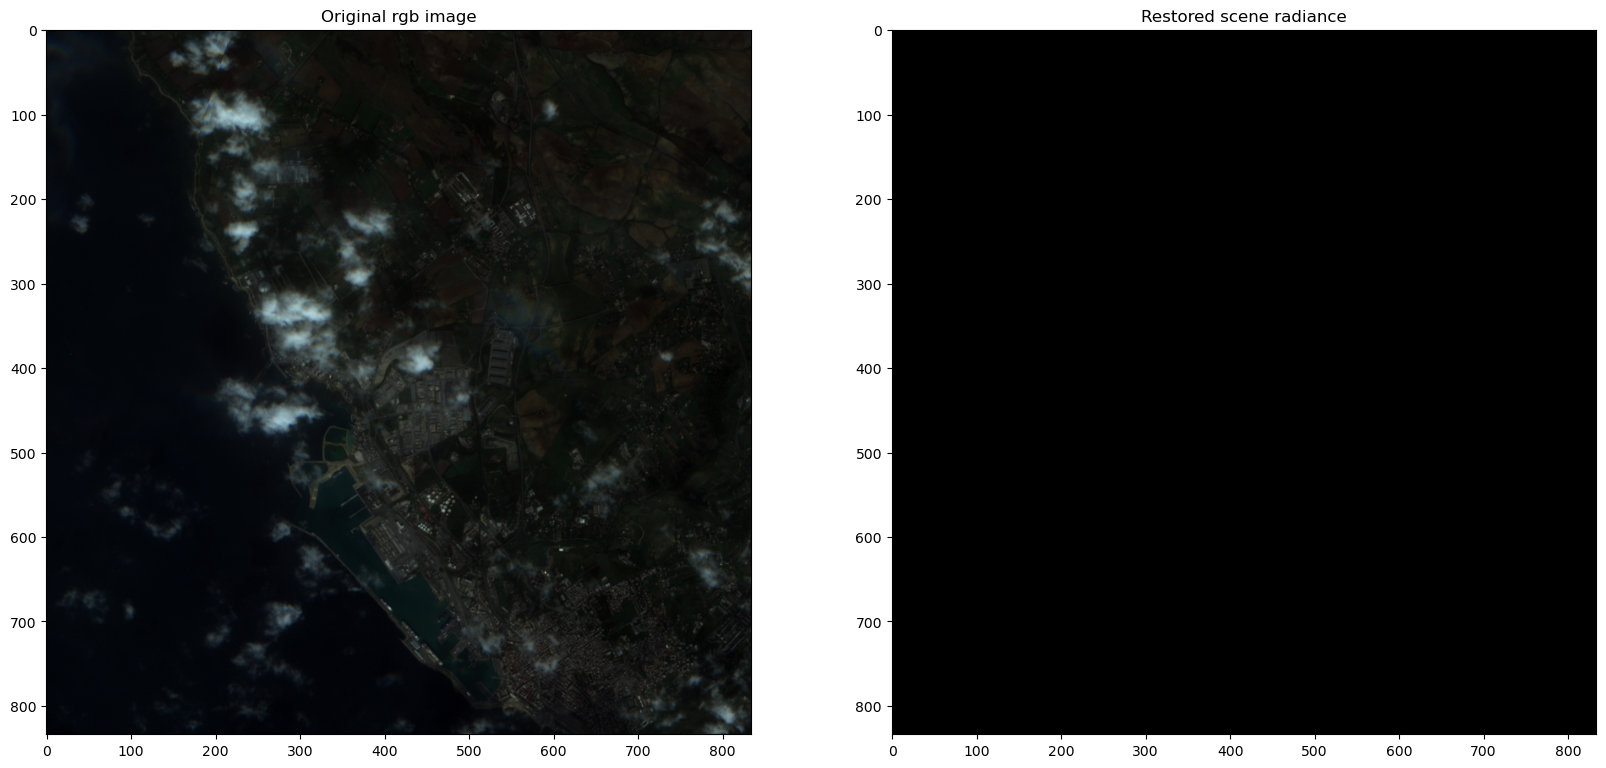

In [5]:
# Global atmospheric light
A = global_atmospheric_light(rgb, dark_channel_rgb)
# Normalization
img_n = normalize(rgb, A)
# Atmospheric veil
V = atmospheric_veil(img_n)
# Transmission
t = transmission(V)
# Restored scene radiance
J = restore_radiance(rgb, A, V, t, t0=0.4, k=10)

# Plot the different steps
fig, axes = plt.subplots(1,6, figsize=(20,10))
axes[0].imshow(rgb)
axes[0].set_title("Original rgb image")
axes[1].imshow(dark_channel_rgb, cmap='gray')
axes[1].set_title("Darkchannel prior")
axes[2].imshow(img_n)
axes[2].set_title("Normalized image")
axes[3].imshow(V, cmap='gray')
axes[3].set_title("Atmospheric veil")
axes[4].imshow(t, cmap='gray')
axes[4].set_title("Transmission")
axes[5].imshow(J)
axes[5].set_title("Restored scene radiance")
plt.suptitle("Different steps of the algorithm", y=0.7)


# Print original image and result
fig, axes = plt.subplots(1,2, figsize=(20,10))
axes[0].imshow(rgb)
axes[0].set_title("Original rgb image")
axes[1].imshow(J)
axes[1].set_title("Restored scene radiance")


### Dehazing tests

Import an image

(834, 834, 10)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0.38650213 0.61503136 0.68641155]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


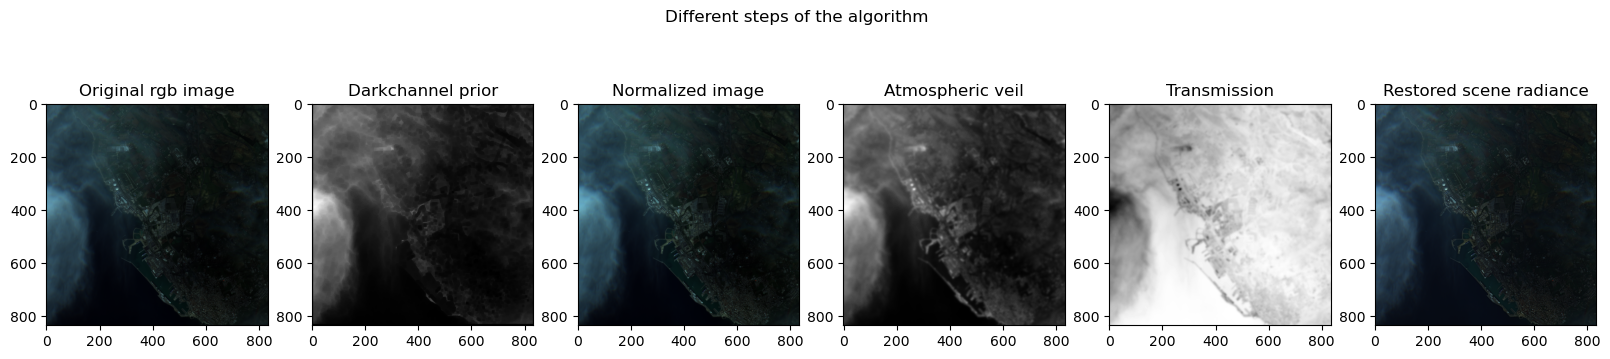

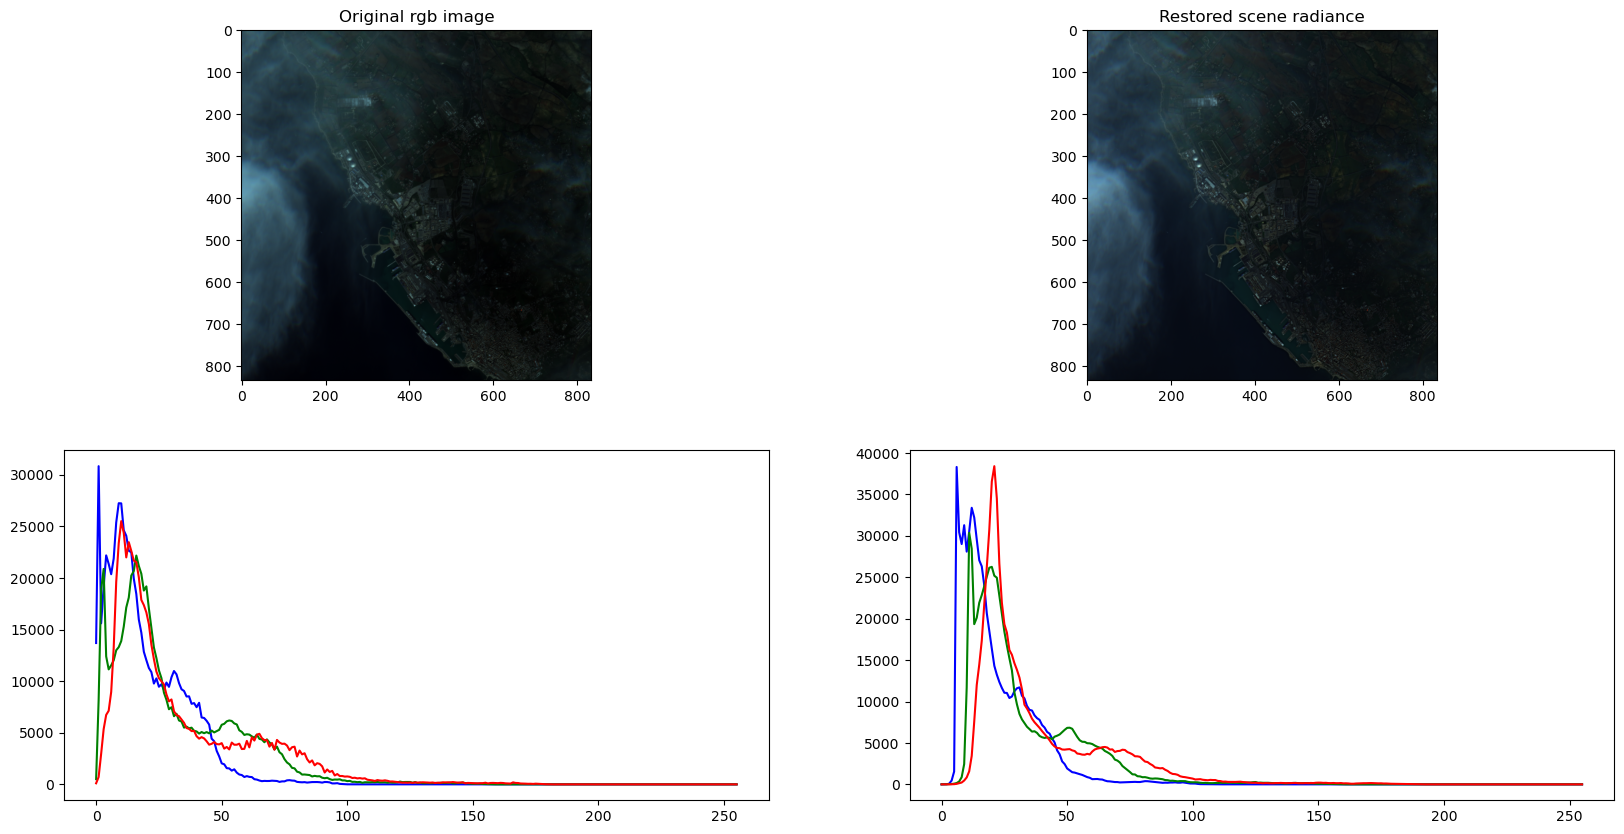

In [6]:
img_name = "Italie_20221017T095919_20221017T100254_T33TTG__orbit_122_DESCENDING_timestamp_1666001351391_cloud_cov_22.606793"
fp = f"../raster/{img_name}.tif"
patch_size = 4
sigma = 3
t0 = 0.7
k = 0.8

# Import array from raster (tif) file
with rasterio.open(fp) as src:
    img = src.read()
# Set 0 values to nan to ignore them afterwards
img = np.where(img==0, np.nan, img)
# Transpose to get an (.,.,10) image with rgb bands
img = np.moveaxis(img, source=0, destination=-1)
print(img.shape)
# Extract rgb bands
rgb = img[:,:,[2,1,0]]

# Normalize bands
rgb = (rgb-np.nanmin(rgb, axis=(0,1)))/(np.nanmax(rgb, axis=(0,1)))

# Plot steps of the algorithm
plot_steps(rgb, patch_size, sigma, t0, k)
# Plot the image vs its restored radiance
plot_comparison(rgb, patch_size, sigma, t0, k)

(628, 832, 3) (624, 828, 3)
[249 253 253]


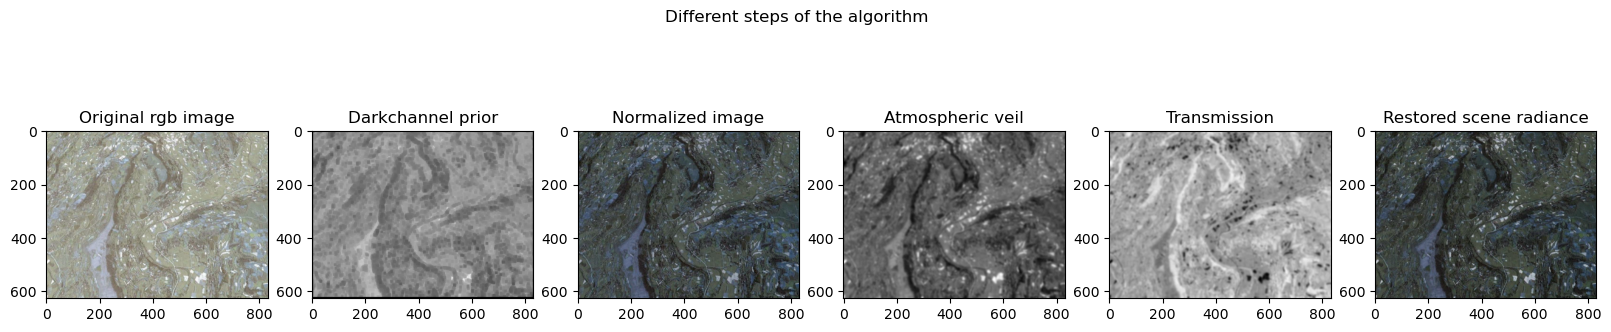

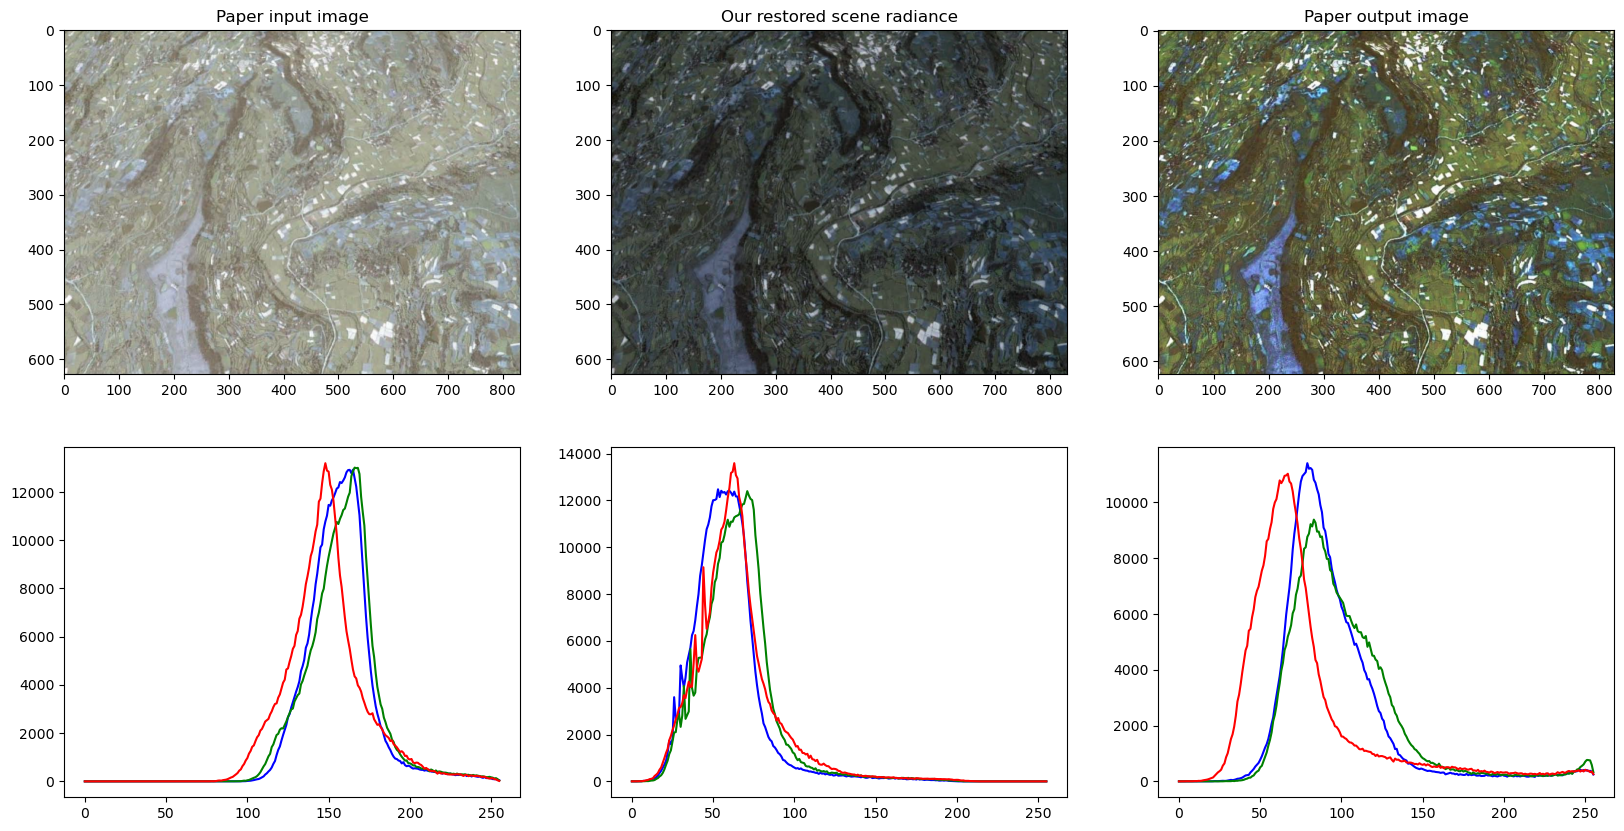

In [7]:
nb = 1

img_name = f"../paper_images/fig_{nb}_input.png"
out_name = f"../paper_images/fig_{nb}_output.png"

patch_size = 4
sigma = 3
t0 = 0.5
k = 0.5

img = cv2.imread(img_name)
out = cv2.imread(out_name)
print(img.shape, out.shape)
# # Plot steps of the algorithm
plot_steps(img, patch_size, sigma, t0, k)

# Compute restored radiance
J = dehazing(img, patch_size, sigma, t0, k)
# Normalization
J = (J-np.nanmin(J, axis=(0,1)))/(np.nanmax(J, axis=(0,1)))

# Print original image vs result
fig, axes = plt.subplots(2,3, figsize=(20,10))
axes[0,0].imshow(img)
axes[0,0].set_title("Paper input image")
axes[0,1].imshow(J)
axes[0,1].set_title("Our restored scene radiance")
axes[0,2].imshow(out)
axes[0,2].set_title("Paper output image")

color = ('b','g','r')

for i,col in enumerate(color):
    histr = cv2.calcHist([img],[i],None,[256],[0,256])
    histJ = cv2.calcHist([(J*255).astype(np.uint16)],[i],None,[256],[0,256])
    histo = cv2.calcHist([out],[i],None,[256],[0,256])
    axes[1,0].plot(histr,color = col)
    axes[1,1].plot(histJ,color = col)
    axes[1,2].plot(histo,color = col)



## Improving contrast of the image

Here, we need to improve the contrast of our image, so as to have an output similar to what the paper had.
To do so, we will implement the Contrast Limited Adaptive Histogram Equalization (CLAHE), using **cv2** library.

In [8]:
def improve_contrast(img, clipLimit, tile_size):
    """ Improves the contrast of an image, using two different methods
    
    Inputs:
        img:                The original image 
        method:             The methode used : "equalizeHist" or "CLAHE"
                         
    Outputs: 
        enhanced_img        The image with improved contrast 
    """
    # converting to LAB color space
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l_channel, a, b = cv2.split(lab)

    # Applying CLAHE to L-channel
    clahe = cv2.createCLAHE(clipLimit=clipLimit, tileGridSize=(tile_size,tile_size))
    cl = clahe.apply(l_channel)

    # merge the CLAHE enhanced L-channel with the a and b channel
    limg = cv2.merge((cl,a,b))

    # Converting image from LAB Color model to BGR color space
    enhanced_img = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)

        
    return enhanced_img

(628, 832, 3) (624, 828, 3)
[249 253 253]


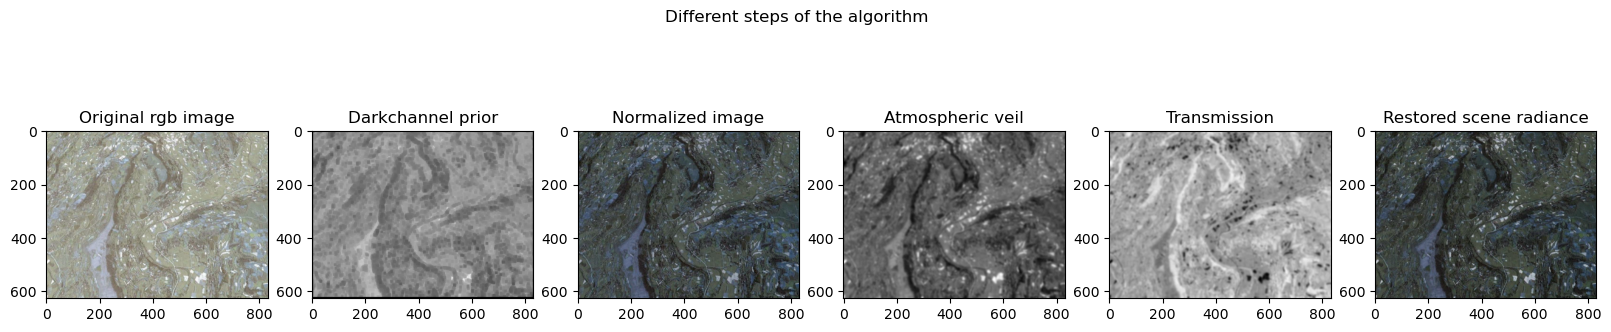

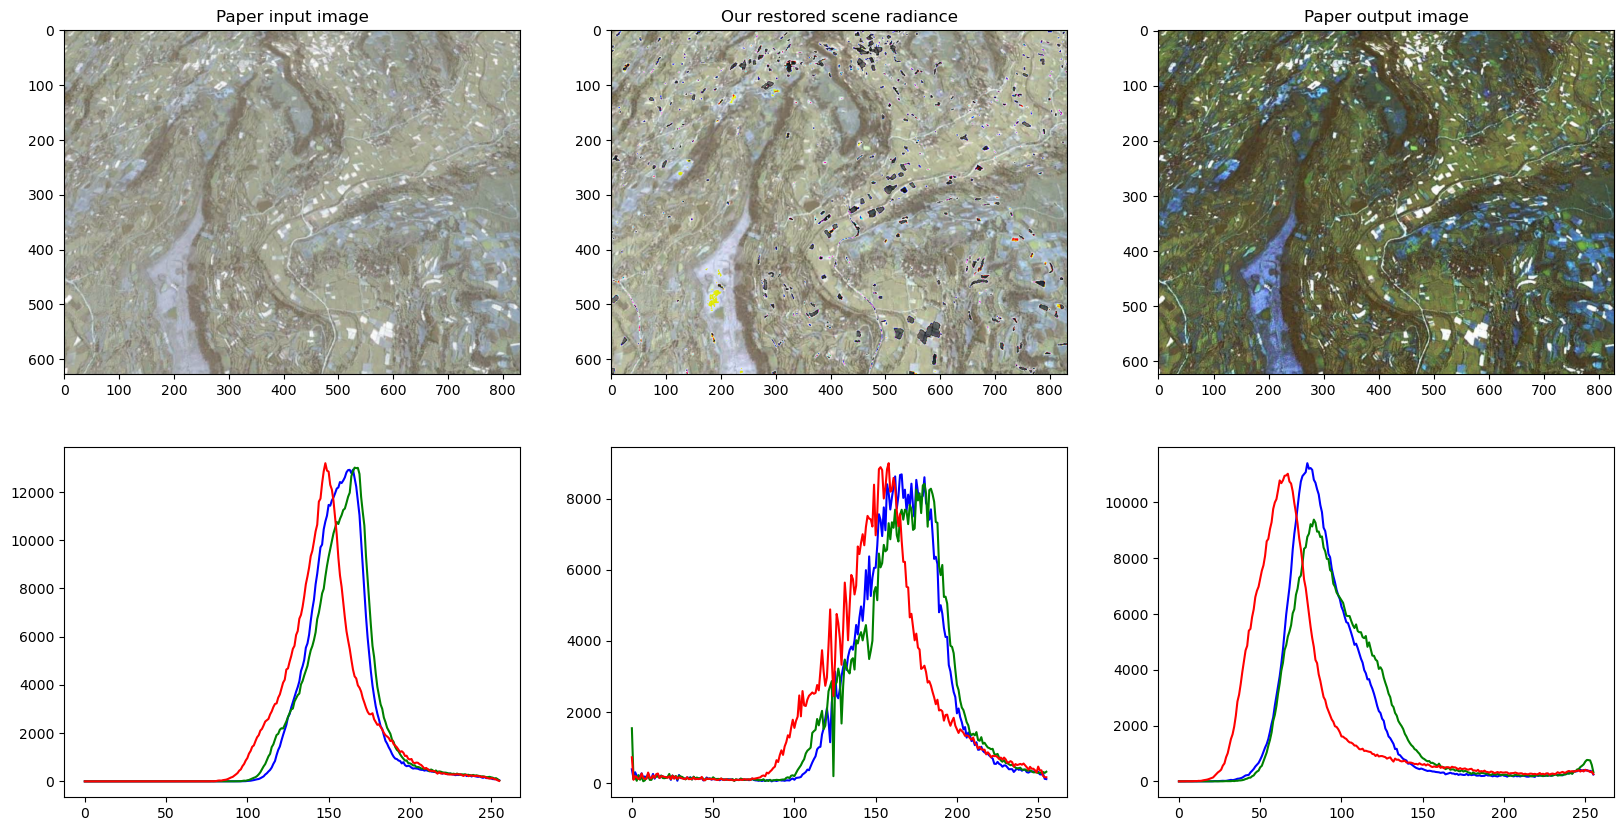

In [9]:
nb = 1

img_name = f"../paper_images/fig_{nb}_input.png"
out_name = f"../paper_images/fig_{nb}_output.png"

patch_size = 4
sigma = 3
t0 = 0.5
k = 0.5

img = cv2.imread(img_name)
out = cv2.imread(out_name)
print(img.shape, out.shape)
# # Plot steps of the algorithm
plot_steps(img, patch_size, sigma, t0, k)

# Compute restored radiance
J = dehazing(img, patch_size, sigma, t0, k)
# Enhancement of contrast 
J = J.astype(np.uint8)
tile_size = 1
clipLimit = 0.1
J = improve_contrast(J, clipLimit, tile_size)
# Normalization
J = (J-np.nanmin(J, axis=(0,1)))/(np.nanmax(J, axis=(0,1)))

# Print original image vs result
fig, axes = plt.subplots(2,3, figsize=(20,10))
axes[0,0].imshow(img)
axes[0,0].set_title("Paper input image")
axes[0,1].imshow(J)
axes[0,1].set_title("Our restored scene radiance, after contrat improvement")
axes[0,2].imshow(out)
axes[0,2].set_title("Paper output image")

color = ('b','g','r')

for i,col in enumerate(color):
    histr = cv2.calcHist([img],[i],None,[256],[0,256])
    histJ = cv2.calcHist([(J*255).astype(np.uint16)],[i],None,[256],[0,256])
    histo = cv2.calcHist([out],[i],None,[256],[0,256])
    axes[1,0].plot(histr,color = col)
    axes[1,1].plot(histJ,color = col)
    axes[1,2].plot(histo,color = col)
